# ClearGrasp evaluation

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
import pandas as pd
import sys
import math
import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.append('../')

import helper_functions
import my_networks

In [4]:
MIN_DEPTH = 450
MAX_DEPTH = 2000
IMG_WIDTH = 1280
IMG_HEIGHT = 720
IMG_WIDTH_NEW = 512
IMG_HEIGHT_NEW = 512

In [5]:
def filter_unmasked(mask, mtx):
    masked_idx = mask == 0
    mtx_copy = np.array(mtx)
    mtx_copy[masked_idx] = 0
    return mtx_copy

In [6]:
def decenter_and_descale_depth_bin(img):
    return helper_functions.decenter_and_descale_depth_bin(img, min_depth=0, max_depth=2000)

In [7]:
data_root_val = '../data/dishwasher2/val/'

In [8]:
def depth_generator(a):
    return helper_functions.depth_generator(a, IMG_HEIGHT, IMG_WIDTH, 0, MAX_DEPTH)

In [9]:
def parse_raw_depth_bin(filename, height, width):
    with open(filename, "rb") as f:
        a = f.read()
        mat = np.ndarray(shape=(height, width, 1), dtype='uint16', buffer=a)
        return mat

In [10]:
cleargrasp_depth_files = sorted(glob.glob(data_root_val + 'cleargrasp_depth/*.bin'))
print(f"ClearGrasp depth size: {len(cleargrasp_depth_files)}")
cleargrasp_depth = [(parse_raw_depth_bin(cleargrasp_depth_file, IMG_HEIGHT, IMG_WIDTH)).astype(np.float32) for cleargrasp_depth_file in cleargrasp_depth_files]

ClearGrasp depth size: 26


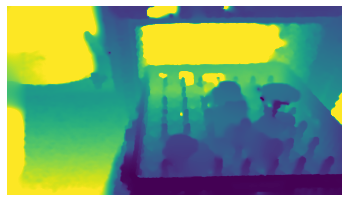

In [ ]:
for i, cgd in enumerate(cleargrasp_depth):
    plt.imshow(cgd, vmin=450, vmax=1000)
    plt.axis('off')
    plt.savefig(f'../data/dishwasher2/val/cleargrasp_depth/{i:0>2}.png', bbox_inches='tight')

In [11]:
def crop_depth(mat):
    m, n, _ = mat.shape
    if m > n:
        margin = int((m - n) / 2)
        return mat[margin:margin+n,:,:]
    elif n > m:
        margin = int((n - m) / 2)
        return mat[:,margin:margin+m,:]
    return mat

In [12]:
def resize_depth(a):
    return helper_functions.resize_depth(a, IMG_HEIGHT_NEW, IMG_WIDTH_NEW)

In [13]:
cleargrasp_depth = [crop_depth(cg) for cg in cleargrasp_depth]
cleargrasp_depth = [resize_depth(cg) for cg in cleargrasp_depth]

In [14]:
cleargrasp = list(iter(cleargrasp_depth))

In [15]:
opaque_depth_matching_files = sorted(glob.glob(data_root_val + '/opaque/depth/*.bin'))
print(f"Opaque depth test size: {len(opaque_depth_matching_files)}")
opaque_depth_matching = tf.data.Dataset.from_generator(depth_generator,
                                                      args=[opaque_depth_matching_files],
                                                      output_types=tf.float64,
                                                      output_shapes=(IMG_HEIGHT, IMG_WIDTH, 1))

Opaque depth test size: 26


In [16]:
transparent_depth_matching_files = sorted(glob.glob(data_root_val + '/transparent/depth/*.bin'))
print(f"Transparent depth test size: {len(transparent_depth_matching_files)}")
transaprent_depth_matching = tf.data.Dataset.from_generator(depth_generator,
                                                      args=[transparent_depth_matching_files],
                                                      output_types=tf.float64,
                                                      output_shapes=(IMG_HEIGHT, IMG_WIDTH, 1))

Transparent depth test size: 26


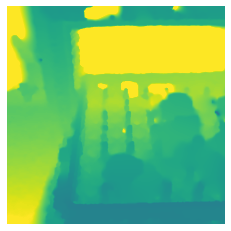

In [17]:
for i, cgd in enumerate(cleargrasp):
    plt.imshow(cgd, vmin=0, vmax=1000)
    plt.axis('off')
    plt.savefig(f'../data/dishwasher2/val/cleargrasp_depth/{i:0>2}_square.png', bbox_inches='tight')

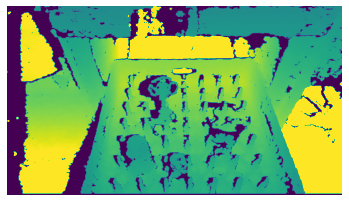

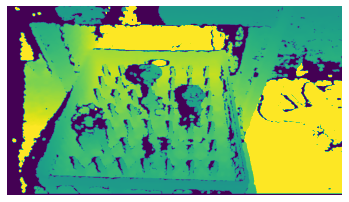

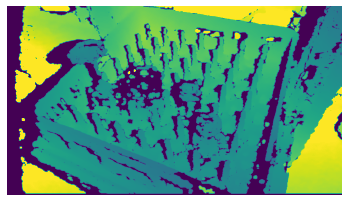

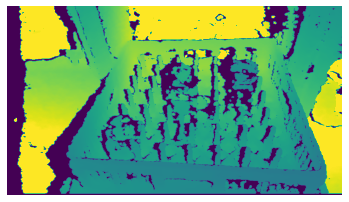

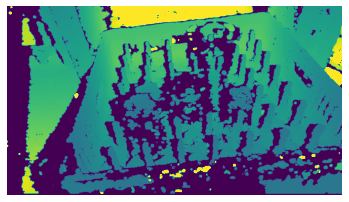

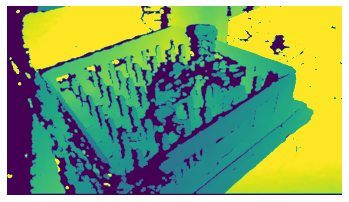

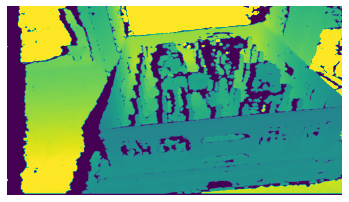

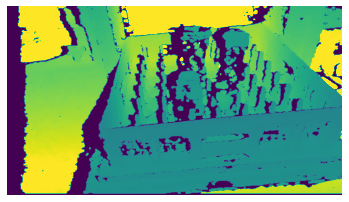

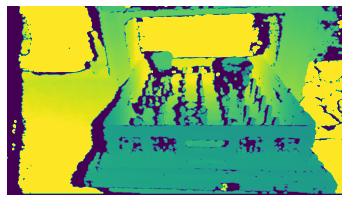

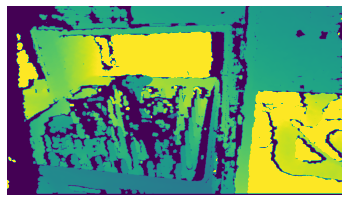

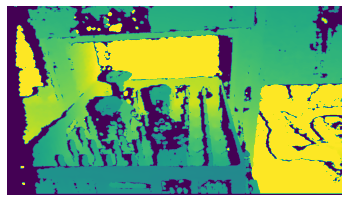

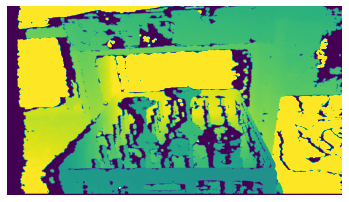

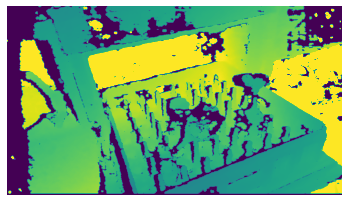

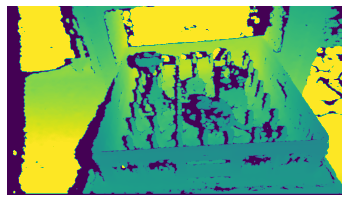

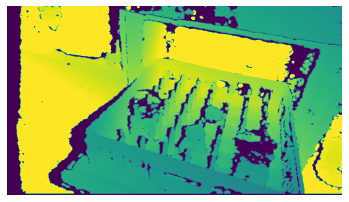

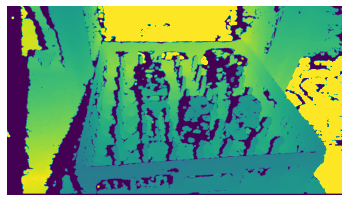

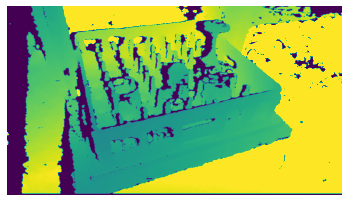

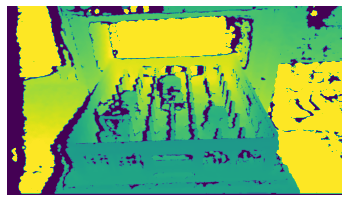

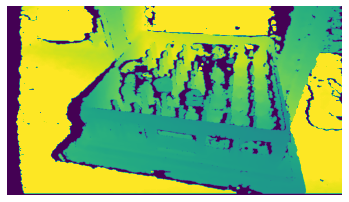

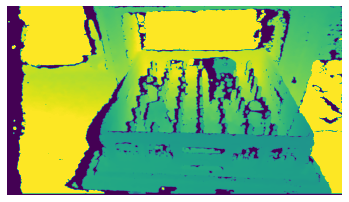

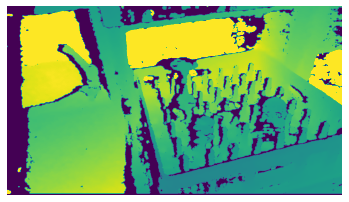

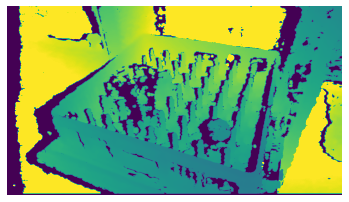

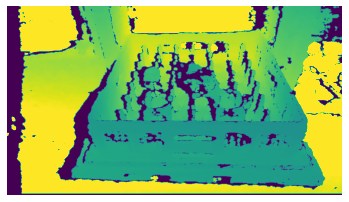

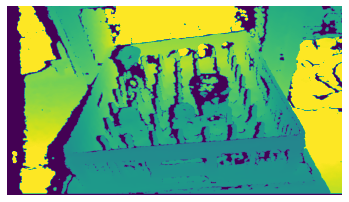

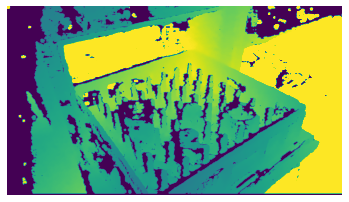

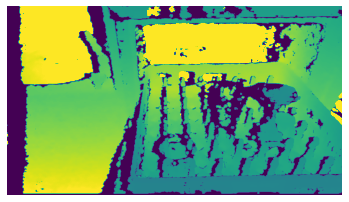

In [17]:
for odm in transaprent_depth_matching:
    depth = decenter_and_descale_depth_bin(odm)
    plt.imshow(depth, vmax=1000)
    plt.axis('off')
    plt.show()

In [ ]:
opaque_color_matching_files = sorted(glob.glob(data_root_val + '/opaque/color/*.png'))
for ocmf in opaque_color_matching_files:
    color_content = imageio.imread(ocmf)
    plt.imshow(color_content)
    plt.axis('off')
    plt.show()

In [16]:
opaque_depth_matching = opaque_depth_matching.map(crop_depth)
opaque_depth_matching = opaque_depth_matching.map(resize_depth)
opaque_depth_matching_max = helper_functions.get_max(list(iter(opaque_depth_matching)))

In [17]:
masks_matching_files = sorted(glob.glob(data_root_val + 'masks/*.bin'))
masks_matching = [np.fromfile(path).reshape(512,512) for path in masks_matching_files]

In [18]:
opaque_depth_match = list(iter(opaque_depth_matching))

In [19]:
def rms(a, b): return np.sqrt(np.mean(np.square(a - b)))
def log_rms(a, b): return np.sqrt(np.mean(np.square(np.log(a) - np.log(b))))
def abs_rel(a, b): return np.mean(np.abs(a - b) / b)
def sq_rel(a, b): return np.mean(np.square(a - b) / b)
def acc(a, b, threshold): return np.count_nonzero(np.maximum(a / b, b / a) < threshold) / a.size

In [20]:
rmse = lambda error: np.sqrt(np.mean(np.square(error)))
mae = lambda error: np.mean(np.abs(error))
me = lambda error: np.mean(error)
rel = lambda estimated, gt: np.abs(estimated - gt) / gt
def thresh(estimated, gt, theta, mask):
    r = rel(estimated, gt)[mask]
    return len(r[r < theta]) / len(r)

In [21]:
def evaluate():
    min_depth = 450
    min_depth_valid = 450
    data = []
    for i in range(len(cleargrasp)):
        depth = cleargrasp[i]
        depth_raw = tf.squeeze(depth)
        gt = opaque_depth_match[i]
        gt_raw = tf.squeeze(decenter_and_descale_depth_bin(gt))
        generated_valid = depth_raw > 450
        gt_valid = gt_raw > min_depth_valid
        mask_valid = tf.squeeze(masks_matching[i] == 1)
        valid = generated_valid & gt_valid
        valid_masked = generated_valid & gt_valid & mask_valid
        
        rel_depth_gt = rel(depth_raw[gt_valid], gt_raw[gt_valid]) if np.any(gt_valid) else np.inf
        rel_depth_gt_match = rel(depth_raw[gt_valid & mask_valid], gt_raw[gt_valid & mask_valid]) if np.any(gt_valid & mask_valid) else np.inf
        
        masked_mae = mae((depth_raw - gt_raw)[valid_masked]) if np.any(valid_masked) > 0 else np.inf
        
        data.append([rmse((depth_raw - gt_raw)[valid]) if np.any(valid) else np.inf,
                     rmse((depth_raw - gt_raw)[valid_masked]) if np.any(valid_masked) else np.inf,
                     mae((depth_raw - gt_raw)[valid]) if np.any(valid) > 0 else np.inf,
                     masked_mae,
                     np.mean(rel_depth_gt),
                     np.mean(rel_depth_gt_match),
                     thresh(depth_raw, gt_raw, 0.05, masks_matching[i] == 1),
                     thresh(depth_raw, gt_raw, 0.10, masks_matching[i] == 1),
                     thresh(depth_raw, gt_raw, 0.25, masks_matching[i] == 1),
                     thresh(depth_raw, gt_raw, (math.pow(1.25, 2) - 1), masks_matching[i] == 1),
                     thresh(depth_raw, gt_raw, (math.pow(1.25, 3) - 1), masks_matching[i] == 1)
                    ])

    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    df = pd.DataFrame(data, 
                      columns=["Generated vs GT RMSE", 
                               "Generated vs GT RMSE (masked)", 
                               "Generated vs GT MAE", 
                               "Generated vs GT MAE (masked)", 
                               "Relative error",
                               "Relative error (masked)",
                               "1.05",
                              "1.10",
                              "1.25",
                              "1.25 ** 2",
                              "1.25 ** 3"])
    df.loc['mean'] = df.mean()
    print(df)

#def evaluate():
#    data = []
#    for i in range(len(cleargrasp)):
#        gt = opaque_depth_match[i]
#        gt_raw = tf.squeeze(decenter_and_descale_depth_bin(gt))
#        cg = tf.squeeze(cleargrasp[i])
#        
#        rel_depth_gt = rel(cg, gt_raw)[gt_raw != 450]
#        rel_depth_gt_match = rel(cg, gt_raw)[(gt_raw != 450) & (masks_matching[i] == 1)]
#        
#        data.append([rmse(gt_raw - cg),
#                     rmse((cg - gt_raw)[(masks_matching[i] == 1) & (gt_raw != 450)]),
#                     mae(gt_raw - cg),
#                     mae((cg - gt_raw)[(masks_matching[i] == 1) & (gt_raw != 450)]),
#                     np.mean(rel_depth_gt),
#                     np.mean(rel_depth_gt_match),
#                     thresh(cg, gt_raw, 0.05, masks_matching[i] == 1),
#                     thresh(cg, gt_raw, 0.10, masks_matching[i] == 1),
#                     thresh(cg, gt_raw, 0.25, masks_matching[i] == 1),
#                     thresh(cg, gt_raw, (math.pow(1.25, 2) - 1), masks_matching[i] == 1),
#                     thresh(cg, gt_raw, (math.pow(1.25, 3) - 1), masks_matching[i] == 1)
#                    ])
#    pd.set_option('display.max_columns', 500)
#    pd.set_option('display.width', 1000)
#    df = pd.DataFrame(data, 
#                      columns=["RMSE(ClearGrasp, GT)", 
#                               "Masked RMSE(ClearGrasp, GT)", 
#                               "MAE(ClearGrasp, GT)", 
#                               "Masked MAE(ClearGrasp, GT)", 
#                               "Relative error",
#                               "Relative error (masked)",
#                               "1.05",
#                               "1.10",
#                               "1.25",
#                               "1.25 ** 2",
#                               "1.25 ** 3"])
#    df.loc['mean'] = df.mean()
#    print(df)
        
evaluate()

      Generated vs GT RMSE  Generated vs GT RMSE (masked)  Generated vs GT MAE  Generated vs GT MAE (masked)  Relative error  Relative error (masked)      1.05      1.10      1.25  1.25 ** 2  1.25 ** 3
0                87.953178                      92.003708            36.683777                     66.205414        0.061054                 0.108609  0.400558  0.490260  0.814544   0.922051   0.925988
1               151.864014                     113.631462            53.722286                     92.916939        0.090613                 0.150454  0.225545  0.375028  0.785399   0.958026   0.961857
2                53.924438                      76.368149            22.496832                     57.309433        0.039465                 0.114787  0.281197  0.507043  0.816830   0.946892   0.950547
3                52.348927                      93.030067            21.786034                     72.093735        0.037435                 0.134282  0.223767  0.438590  0.833219   0.944035  

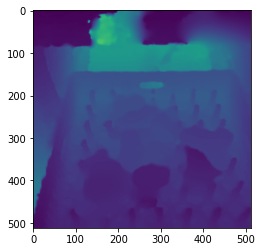

In [22]:
plt.imshow(cleargrasp[0])

In [23]:
def crop_depth_d2d(mat):
    print(mat.shape)
    m, n, _ = mat.shape
    if m > n:
        margin = int((m - n) / 2)
        return mat[margin:margin+n,:]
    elif n > m:
        margin = int((n - m) / 2)
        return mat[:,margin:margin+m,:]
    return mat

In [24]:
print(np.mean(decenter_and_descale_depth_bin(cleargrasp[0])))

759258.7


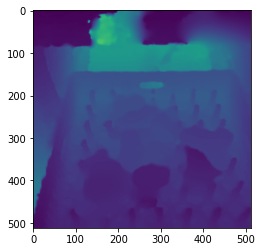

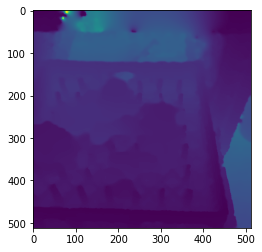

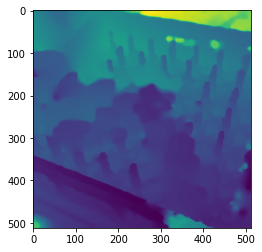

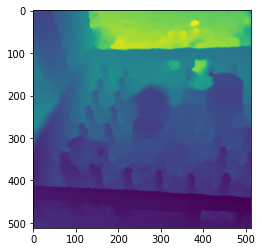

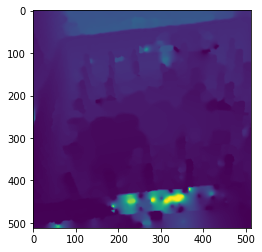

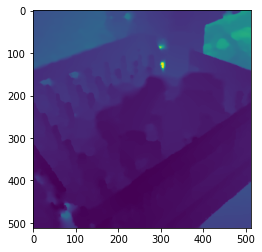

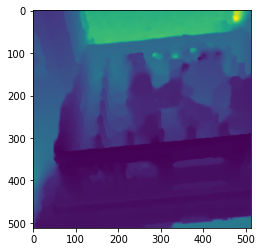

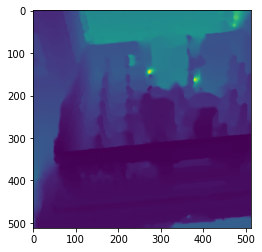

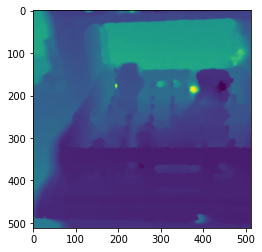

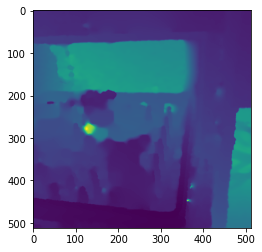

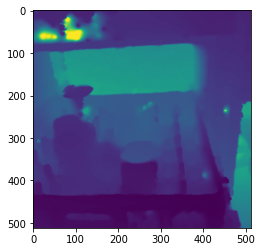

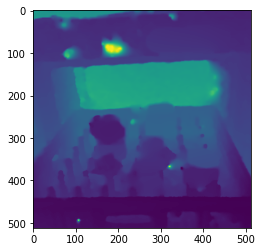

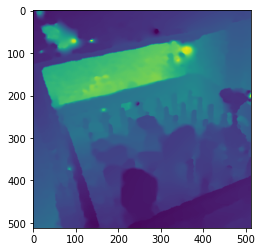

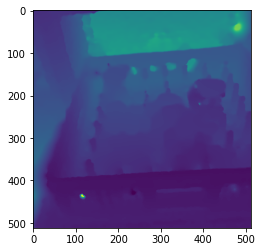

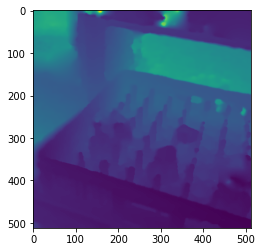

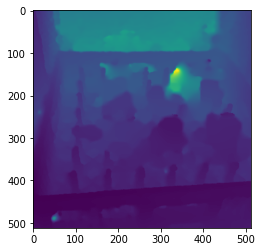

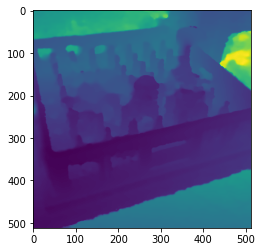

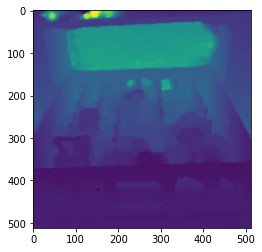

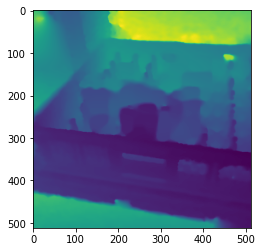

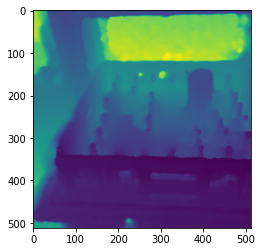

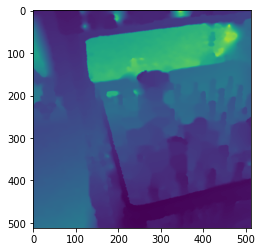

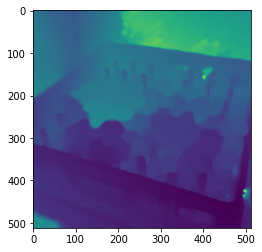

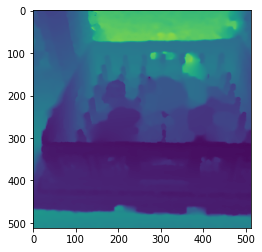

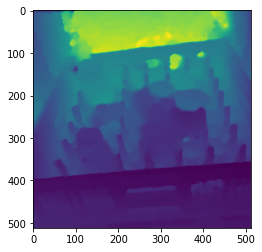

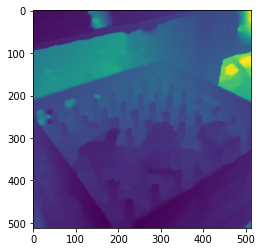

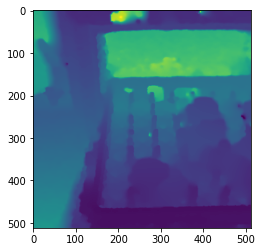

In [25]:
for i in range(len(cleargrasp)):
    depth = cleargrasp[i]
    plt.imshow(depth)
    plt.show()

In [26]:
plt.imshow(normals)

NameError: name 'normals' is not defined

In [ ]:
from utils import exr_loader

In [ ]:
normals_cg = exr_loader('../data/cleargrasp-dataset-test-val/real-val/d435/000000000-normals.exr', ndim=3)

In [ ]:
# from ClearGrasp
def normal_to_rgb(normals_to_convert, output_dtype='float'):
    '''Converts a surface normals array into an RGB image.
    Surface normals are represented in a range of (-1,1),
    This is converted to a range of (0,255) for a numpy image, or a range of (0,1) to represent PIL Image.
    The surface normals' axes are mapped as (x,y,z) -> (R,G,B).
    Args:
        normals_to_convert (numpy.ndarray): Surface normals, dtype float32, range [-1, 1]
        output_dtype (str): format of output, possibel values = ['float', 'uint8']
                            if 'float', range of output (0,1)
                            if 'uint8', range of output (0,255)
    '''
    camera_normal_rgb = (normals_to_convert + 1) / 2
    if output_dtype == 'uint8':
        camera_normal_rgb *= 255
        camera_normal_rgb = camera_normal_rgb.astype(np.uint8)
    elif output_dtype == 'float':
        pass
    else:
        raise NotImplementedError('Possible values for "output_dtype" are only float and uint8. received value {}'.format(output_dtype))

    return camera_normal_rgb

In [ ]:
plt.imshow(normal_to_rgb(normals_cg.transpose((1, 2, 0)), output_dtype='uint8'))

In [ ]:
for i in range(len(cleargrasp_depth)):
    depth = cleargrasp_depth[i]
    plt.imshow(depth, vmax=1000)
    plt.axis('off')
    plt.show()